In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
from sklearn.model_selection import GridSearchCV

In [2]:
# CSV dataset file name
file_name = 'D2.csv'

In [3]:
# Please put csv file in the same folder with this jupyter notebook
df_prep = pd.read_csv(file_name)

In [4]:
print(df_prep.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 30 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   race                      20000 non-null  object
 1   gender                    20000 non-null  object
 2   age                       20000 non-null  object
 3   admission_type_id         20000 non-null  int64 
 4   discharge_disposition_id  20000 non-null  int64 
 5   admission_source_id       20000 non-null  int64 
 6   time_in_hospital          20000 non-null  int64 
 7   medical_specialty         20000 non-null  object
 8   num_lab_procedures        20000 non-null  int64 
 9   num_procedures            20000 non-null  int64 
 10  num_medications           20000 non-null  int64 
 11  number_outpatient         20000 non-null  int64 
 12  number_emergency          20000 non-null  int64 
 13  number_inpatient          20000 non-null  int64 
 14  number_diagnoses      

# Predictive modelling using Regression

# 1. Pre-processing

### a. Check Invalid values

In [5]:
#Checking for missing values in dataset
#In the dataset missing values are represented as '?' sign
def checkInvalidValue(value):
    print('**********************************')
    print(f'Checking for missing ' + value)
    for col in df_prep.columns:
        if df_prep[col].dtype == object:
            print(col,df_prep[col][df_prep[col] == value].count())

In [6]:
checkInvalidValue('?')
checkInvalidValue('NaN')
checkInvalidValue('Unknown/Invalid')


**********************************
Checking for missing ?
race 0
gender 0
age 0
medical_specialty 0
max_glu_serum 0
A1Cresult 0
metformin 0
repaglinide 0
nateglinide 0
chlorpropamide 0
glimepiride 0
acetohexamide 0
glipizide 0
glyburide 0
tolbutamide 0
insulin 0
**********************************
Checking for missing NaN
race 0
gender 0
age 0
medical_specialty 0
max_glu_serum 0
A1Cresult 0
metformin 0
repaglinide 0
nateglinide 0
chlorpropamide 0
glimepiride 0
acetohexamide 0
glipizide 0
glyburide 0
tolbutamide 0
insulin 0
**********************************
Checking for missing Unknown/Invalid
race 0
gender 0
age 0
medical_specialty 0
max_glu_serum 0
A1Cresult 0
metformin 0
repaglinide 0
nateglinide 0
chlorpropamide 0
glimepiride 0
acetohexamide 0
glipizide 0
glyburide 0
tolbutamide 0
insulin 0


### b. Variables

###### Create a new collumn name medchange to record the changing in 10 drugs that have correlation to diabetes patient readmission
###### No, Steady: 0
###### Yes: 1

In [7]:
variables = ['metformin', 'repaglinide', 'nateglinide', 'chlorpropamide', 'glimepiride', 
'acetohexamide', 'glipizide', 'glyburide', 'tolbutamide', 'insulin']
for col in variables:
    colname = str(col) + 'temp'
    df_prep[colname] = df_prep[col].apply(lambda x: 0 if (x == 'No' or x == 'Steady') else 1)
df_prep['medchange'] = 0
for col in variables:
    colname = str(col) + 'temp'
    df_prep['medchange'] = df_prep['medchange'] + df_prep[colname]
    del df_prep[colname]
    
df_prep['medchange'].value_counts()  

0    13610
1     6085
2      279
3       26
Name: medchange, dtype: int64

Encoding some category variables to numeric values

In [8]:
df_prep['change'] = df_prep['change'].replace(True, 1)
df_prep['change'] = df_prep['change'].replace(False, 0)
df_prep['gender'] = df_prep['gender'].replace('Male', 1)
df_prep['gender'] = df_prep['gender'].replace('Female', 0)
df_prep['diabetesMed'] = df_prep['diabetesMed'].replace(True, 1)
df_prep['diabetesMed'] = df_prep['diabetesMed'].replace(False, 0)

# Medicine change
for col in variables:
    df_prep[col] = df_prep[col].replace('No', 0)
    df_prep[col] = df_prep[col].replace('Steady', 1)
    df_prep[col] = df_prep[col].replace('Up', 1)
    df_prep[col] = df_prep[col].replace('Down', 1)

Mapping values for A1Cresult, max_glu_serum to numeric values

In [9]:
df_prep['A1Cresult'] = df_prep['A1Cresult'].replace('>7', 1)
df_prep['A1Cresult'] = df_prep['A1Cresult'].replace('>8', 1)
df_prep['A1Cresult'] = df_prep['A1Cresult'].replace('Norm', 0)
df_prep['A1Cresult'] = df_prep['A1Cresult'].replace('None', -99)
df_prep['max_glu_serum'] = df_prep['max_glu_serum'].replace('>200', 1)
df_prep['max_glu_serum'] = df_prep['max_glu_serum'].replace('>300', 1)
df_prep['max_glu_serum'] = df_prep['max_glu_serum'].replace('Norm', 0)
df_prep['max_glu_serum'] = df_prep['max_glu_serum'].replace('None', -99)

Age mapping

In [10]:
# mapping
age_map = {'[0-10)':1, '[10-20)':2, '[20-30)':3, '[30-40)':4, '[40-50)':5, '[50-60)':6, '[60-70)':7, '[70-80)':8, '[80-90)':9, '[90-100)':10}
#print(age_map)
df_prep['age'] = df_prep['age'].map(age_map)
print(df_prep['age'].unique())

[ 9  8  6  5  7 10  4  2  3  1]


In [11]:
# mapping
race_map = {'AfricanAmerican':1, 'Asian':2, 'Caucasian':3, 'Hispanic':4, 'Other':5}
#print(age_map)
df_prep['race'] = df_prep['race'].map(race_map)
print(df_prep['race'].unique())

[1 3 5 2 4]


Consider dropping for medical_specialty for missing a lot of information, and it may not affect to our predictive model. 
Dropping race because it doesn't help in predictive model

In [12]:
df_prep = df_prep.drop(['medical_specialty'], axis = 1)

In [13]:
df_prep.head().T

,0,1,2,3,4
race,1,3,3,1,1
gender,0,0,0,0,1
age,9,8,6,6,9
admission_type_id,1,1,3,1,1
discharge_disposition_id,3,3,1,1,3
admission_source_id,7,5,1,7,7
time_in_hospital,1,3,3,6,4
num_lab_procedures,33,48,25,41,22
num_procedures,0,2,1,0,0
num_medications,14,7,15,19,12


In [14]:
df_prep.dtypes

race                        int64
gender                      int64
age                         int64
admission_type_id           int64
discharge_disposition_id    int64
admission_source_id         int64
time_in_hospital            int64
num_lab_procedures          int64
num_procedures              int64
num_medications             int64
number_outpatient           int64
number_emergency            int64
number_inpatient            int64
number_diagnoses            int64
max_glu_serum               int64
A1Cresult                   int64
metformin                   int64
repaglinide                 int64
nateglinide                 int64
chlorpropamide              int64
glimepiride                 int64
acetohexamide               int64
glipizide                   int64
glyburide                   int64
tolbutamide                 int64
insulin                     int64
change                      int64
diabetesMed                 int64
readmitted                  int64
medchange     

In [15]:
from sklearn.model_selection import train_test_split

def data_prep(df_prep):
    # one-hot encoding
    df = pd.get_dummies(df_prep)
    
    # target/input split
    y = df['readmitted']
    X = df.drop(['readmitted'], axis=1)

    # setting random state
    rs = 10

    X_mat = X.to_numpy()
    X_train, X_test, y_train, y_test = train_test_split(X_mat, y, test_size=0.3, stratify=y, random_state=rs)
    
    return df,X,y,X_train, X_test, y_train, y_test

In [16]:
df,X,y,X_train, X_test, y_train, y_test = data_prep(df_prep)
print(df.columns[28])

readmitted


In [17]:
#X_mat = X.to_numpy()

## 2. Building the first logistic regression model <a name="build"></a>

### 2.1. Standardisation

In [18]:
from sklearn.preprocessing import StandardScaler

# initialise a standard scaler object
scaler = StandardScaler()

# visualise min, max, mean and standard dev of data before scaling
print("Before scaling\n-------------")
for i in range(5):
    col = X_train[:,i]
    print("Variable #{}: min {}, max {}, mean {:.2f} and std dev {:.2f}".
          format(i, min(col), max(col), np.mean(col), np.std(col)))

# learn the mean and std.dev of variables from training data
# then use the learned values to transform training data
X_train = scaler.fit_transform(X_train, y_train)

print("After scaling\n-------------")
for i in range(5):
    col = X_train[:,i]
    print("Variable #{}: min {}, max {}, mean {:.2f} and std dev {:.2f}".
          format(i, min(col), max(col), np.mean(col), np.std(col)))

# use the statistic that you learned from training to transform test data
# NEVER learn from test data, this is supposed to be a set of dataset
# that the model has never seen before
X_test = scaler.transform(X_test)

Before scaling
-------------
Variable #0: min 1, max 5, mean 2.73 and std dev 0.81
Variable #1: min 0, max 1, mean 0.46 and std dev 0.50
Variable #2: min 1, max 10, mean 7.18 and std dev 1.57
Variable #3: min 1, max 8, mean 1.81 and std dev 1.21
Variable #4: min 1, max 28, mean 3.18 and std dev 4.35
After scaling
-------------
Variable #0: min -2.131860544576406, max 2.7972967839239544, mean 0.00 and std dev 1.00
Variable #1: min -0.92348913710008, max 1.0828497703178466, mean -0.00 and std dev 1.00
Variable #2: min -3.939541810142892, max 1.7974560757140987, mean 0.00 and std dev 1.00
Variable #3: min -0.6710221875474691, max 5.125890222506477, mean 0.00 and std dev 1.00
Variable #4: min -0.5018574673834632, max 5.708314486358282, mean 0.00 and std dev 1.00


### 2.2. Training logistic regression

In [19]:
from sklearn.linear_model import LogisticRegression

In [20]:
rs = 10
model_default = LogisticRegression(random_state=rs)

# fit it to training data
model_default.fit(X_train, y_train)

LogisticRegression(random_state=10)

In [21]:
# training and test accuracy
print("Train accuracy:", model_default.score(X_train, y_train))
print("Test accuracy:", model_default.score(X_test, y_test))

# classification report on test data
y_pred = model_default.predict(X_test)
print(classification_report(y_test, y_pred))

Train accuracy: 0.6315
Test accuracy: 0.6238333333333334
              precision    recall  f1-score   support

           0       0.62      0.78      0.69      3203
           1       0.64      0.44      0.52      2797

    accuracy                           0.62      6000
   macro avg       0.63      0.61      0.61      6000
weighted avg       0.63      0.62      0.61      6000



## 3. Understanding the logistic regression model

In [22]:
print(model_default.coef_)

[[ 0.02808085 -0.00367593  0.07022501 -0.06366601 -0.0739621   0.01823718
  -0.01358197  0.01155575 -0.07904625  0.10904082  0.16287406  0.22202603
   0.52983428  0.082577    0.07570475 -0.00274079 -0.1061166   0.0105743
  -0.02144048  0.02102291 -0.02700549  0.         -0.01834765  0.00199773
   0.         -0.14301422  0.05868946  0.20848896  0.06592545]]


In [23]:
feature_names = X.columns
coef = model_default.coef_[0]

# limit to 30 features, you can comment the following line to print out everything
coef = coef[:30]

for i in range(len(coef)):
    print(feature_names[i], ':', coef[i])

race : 0.028080846984020802
gender : -0.0036759270189715343
age : 0.0702250099575811
admission_type_id : -0.06366601074207315
discharge_disposition_id : -0.07396209662804319
admission_source_id : 0.01823718317267331
time_in_hospital : -0.01358196691844002
num_lab_procedures : 0.01155574552641522
num_procedures : -0.07904624856031559
num_medications : 0.109040816742026
number_outpatient : 0.16287406444903305
number_emergency : 0.2220260280466283
number_inpatient : 0.5298342843881187
number_diagnoses : 0.08257699862863763
max_glu_serum : 0.07570474686389353
A1Cresult : -0.0027407855219878483
metformin : -0.1061166014090236
repaglinide : 0.01057429950803438
nateglinide : -0.021440476544603692
chlorpropamide : 0.02102290777085563
glimepiride : -0.027005486191670935
acetohexamide : 0.0
glipizide : -0.018347650108941314
glyburide : 0.001997726291615074
tolbutamide : 0.0
insulin : -0.14301422059560662
change : 0.05868945983423367
diabetesMed : 0.20848896140684986
medchange : 0.065925446613906

In [24]:
# grab feature importances from the model and feature name from the original X
coef = model_default.coef_[0]
feature_names = X.columns

# sort them out in descending order
indices = np.argsort(np.absolute(coef))
indices = np.flip(indices, axis=0)

# limit to 30 features, you can leave this out to print out everything
indices = indices[:30]

for i in indices:
    print(feature_names[i], ':', coef[i])

number_inpatient : 0.5298342843881187
number_emergency : 0.2220260280466283
diabetesMed : 0.20848896140684986
number_outpatient : 0.16287406444903305
insulin : -0.14301422059560662
num_medications : 0.109040816742026
metformin : -0.1061166014090236
number_diagnoses : 0.08257699862863763
num_procedures : -0.07904624856031559
max_glu_serum : 0.07570474686389353
discharge_disposition_id : -0.07396209662804319
age : 0.0702250099575811
medchange : 0.06592544661390609
admission_type_id : -0.06366601074207315
change : 0.05868945983423367
race : 0.028080846984020802
glimepiride : -0.027005486191670935
nateglinide : -0.021440476544603692
chlorpropamide : 0.02102290777085563
glipizide : -0.018347650108941314
admission_source_id : 0.01823718317267331
time_in_hospital : -0.01358196691844002
num_lab_procedures : 0.01155574552641522
repaglinide : 0.01057429950803438
gender : -0.0036759270189715343
A1Cresult : -0.0027407855219878483
glyburide : 0.001997726291615074
acetohexamide : 0.0
tolbutamide : 0

Based on this output, the top-3 important variables in this model are number_inpatient, number_emergency, and diabetesMed. The ordering of important variables may differ different between models.

## 4. Finding optimal hyperparameters with GridSearchCV 

In [25]:
# grid search CV
params = {'C': [pow(10, x) for x in range(-6, 4)]}

# use all cores to tune logistic regression with C parameter
model_cv = GridSearchCV(param_grid=params, estimator=LogisticRegression(random_state=rs),return_train_score=True, cv=10, n_jobs=-1)
model_cv.fit(X_train, y_train)

GridSearchCV(cv=10, estimator=LogisticRegression(random_state=10), n_jobs=-1,
             param_grid={'C': [1e-06, 1e-05, 0.0001, 0.001, 0.01, 0.1, 1, 10,
                               100, 1000]},
             return_train_score=True)

In [26]:
result_set = model_cv.cv_results_
print(result_set)

{'mean_fit_time': array([0.05108204, 0.03891439, 0.04843879, 0.05654182, 0.07467725,
       0.08448873, 0.07434649, 0.08626373, 0.06541176, 0.05998232]), 'std_fit_time': array([0.01892846, 0.00409795, 0.00590354, 0.01124806, 0.02527135,
       0.03021179, 0.02709992, 0.02550352, 0.01845483, 0.0132306 ]), 'mean_score_time': array([0.00130107, 0.00139842, 0.00166669, 0.00144022, 0.00501318,
       0.00112832, 0.00158873, 0.00148544, 0.00207038, 0.00100186]), 'std_score_time': array([0.00063137, 0.00061298, 0.00169577, 0.00091942, 0.01016268,
       0.00037416, 0.00059383, 0.00065241, 0.00255888, 0.0006323 ]), 'param_C': masked_array(data=[1e-06, 1e-05, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100,
                   1000],
             mask=[False, False, False, False, False, False, False, False,
                   False, False],
       fill_value='?',
            dtype=object), 'params': [{'C': 1e-06}, {'C': 1e-05}, {'C': 0.0001}, {'C': 0.001}, {'C': 0.01}, {'C': 0.1}, {'C': 1}, {'C': 10}, {'C'

Total number of models:  10


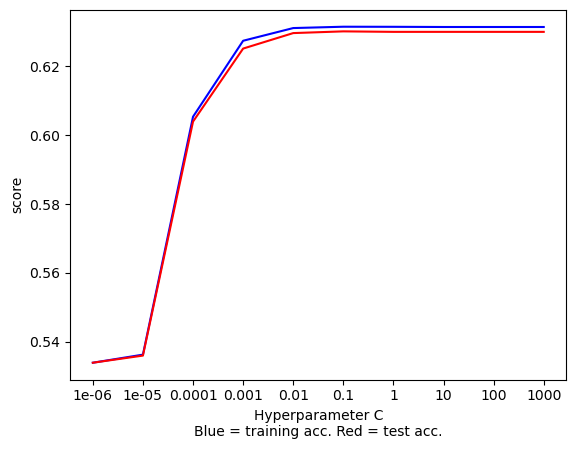

In [27]:
import matplotlib.pyplot as plt

train_result = result_set['mean_train_score']
test_result = result_set['mean_test_score']
print("Total number of models: ", len(test_result))
# plot Hyperparameter C values vs training and test accuracy score
plt.plot(range(0, len(train_result)), train_result, 'b', range(0,len(test_result)), test_result, 'r')
plt.xlabel('Hyperparameter C\nBlue = training acc. Red = test acc.')
plt.xticks(range(0, len(train_result)),[pow(10, x) for x in range(-6, 4)])
plt.ylabel('score')
plt.show()

Overfitting????? Overfitting refers to a model that models the training data too well.

In [28]:
print(model_cv.best_params_)

{'C': 0.1}


In [29]:
model_cv.fit(X_train, y_train)

print("Train accuracy:", model_cv.score(X_train, y_train))
print("Test accuracy:", model_cv.score(X_test, y_test))

Train accuracy: 0.6313571428571428
Test accuracy: 0.6236666666666667


Default:
Train accuracy: 0.6315
Test accuracy: 0.6238333333333334

## 5. Feature selection. Reduce variables set

In [30]:
from sklearn.feature_selection import RFECV

rfe = RFECV(estimator = LogisticRegression(random_state=rs), cv=10)
rfe.fit(X_train, y_train) # run the RFECV

# comparing how many variables before and after
print("Original feature set", X_train.shape[1])
print("Number of features after elimination", rfe.n_features_)

Original feature set 29
Number of features after elimination 24


In [31]:
X_train_sel = rfe.transform(X_train)
X_test_sel = rfe.transform(X_test)

In [32]:
# grid search CV
params = {'C': [pow(10, x) for x in range(-6, 4)]}

rfe_cv = GridSearchCV(param_grid=params, estimator=LogisticRegression(random_state=rs), cv=10, n_jobs=-1, return_train_score=True)
rfe_cv.fit(X_train_sel, y_train)

# test the best model
print("Train accuracy:", rfe_cv.score(X_train_sel, y_train))
print("Test accuracy:", rfe_cv.score(X_test_sel, y_test))

y_pred = rfe_cv.predict(X_test_sel)
print(classification_report(y_test, y_pred))

# print parameters of the best model
print(rfe_cv.best_params_)

Train accuracy: 0.6310714285714286
Test accuracy: 0.6243333333333333
              precision    recall  f1-score   support

           0       0.62      0.78      0.69      3203
           1       0.64      0.44      0.52      2797

    accuracy                           0.62      6000
   macro avg       0.63      0.61      0.61      6000
weighted avg       0.63      0.62      0.61      6000

{'C': 1}


Better Test Accuracy

In [33]:
result_set = rfe_cv.cv_results_
print(result_set)

{'mean_fit_time': array([0.02780006, 0.02671685, 0.03807914, 0.04222343, 0.05057929,
       0.05734136, 0.05304844, 0.0581573 , 0.06035678, 0.05734355]), 'std_fit_time': array([0.00442744, 0.00619947, 0.00609302, 0.00727886, 0.00975527,
       0.01256378, 0.01072765, 0.0109714 , 0.01184073, 0.01654115]), 'mean_score_time': array([4.00710106e-04, 9.98497009e-05, 1.81195736e-03, 9.01293755e-04,
       1.16381645e-03, 1.19957924e-03, 1.52544975e-03, 8.71443748e-04,
       1.22125149e-03, 9.58204269e-04]), 'std_score_time': array([0.00120213, 0.00029955, 0.00232143, 0.00151754, 0.0013002 ,
       0.0010488 , 0.00149434, 0.00053974, 0.00057057, 0.00046955]), 'param_C': masked_array(data=[1e-06, 1e-05, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100,
                   1000],
             mask=[False, False, False, False, False, False, False, False,
                   False, False],
       fill_value='?',
            dtype=object), 'params': [{'C': 1e-06}, {'C': 1e-05}, {'C': 0.0001}, {'C': 0.001}, {'C

Total number of models:  10


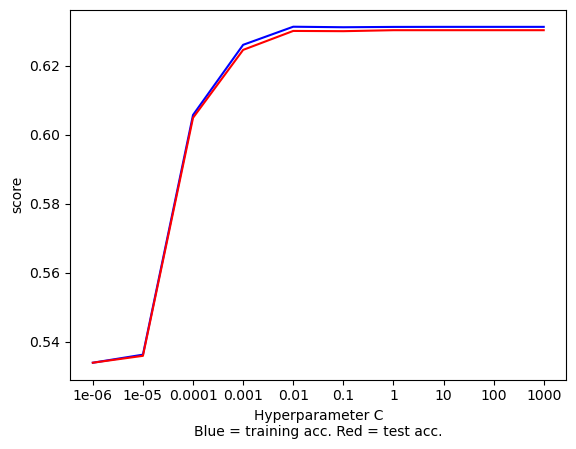

In [34]:
train_result = result_set['mean_train_score']
test_result = result_set['mean_test_score']
print("Total number of models: ", len(test_result))
# plot Hyperparameter C values vs training and test accuracy score
plt.plot(range(0, len(train_result)), train_result, 'b', range(0,len(test_result)), test_result, 'r')
plt.xlabel('Hyperparameter C\nBlue = training acc. Red = test acc.')
plt.xticks(range(0, len(train_result)),[pow(10, x) for x in range(-6, 4)])
plt.ylabel('score')
plt.show()

In [35]:
# grab feature importances from the model and feature name from the original X
coef = rfe_cv.best_estimator_.coef_[0]
feature_names = X.columns

# sort them out in descending order
indices = np.argsort(np.absolute(coef))
indices = np.flip(indices, axis=0)

# limit to 30 features, you can leave this out to print out everything
indices = indices[:30]

for i in indices:
    print(feature_names[i], ':', coef[i])

number_emergency : 0.5300679328142393
number_outpatient : 0.22230728787833173
glipizide : 0.20908796396925863
num_medications : 0.16304166512766732
glimepiride : -0.14379687083223014
num_procedures : 0.10950030452257008
max_glu_serum : -0.1063146083024962
number_inpatient : 0.08239230358455565
num_lab_procedures : -0.07917530062138523
number_diagnoses : 0.07574001593897037
admission_type_id : -0.07383932839823253
gender : 0.07099889524928077
glyburide : 0.06538666099287718
age : -0.06379182668022498
acetohexamide : 0.05939703550766962
race : 0.02787605686957478
nateglinide : -0.027441161699198656
metformin : -0.021639524287039205
repaglinide : 0.020915565571804122
chlorpropamide : -0.01903638641368969
discharge_disposition_id : 0.018121975171796277
admission_source_id : -0.013477680269238278
time_in_hospital : 0.010813608216432303
A1Cresult : 0.01033194103663439


## 6. ROC

In [36]:
from sklearn.metrics import roc_auc_score

y_pred_proba_dt = model_default.predict_proba(X_test)
y_pred_proba_dt_cv = model_cv.predict_proba(X_test)
y_pred_proba_rfe = rfe_cv.predict_proba(X_test_sel)

roc_index_dt = roc_auc_score(y_test, y_pred_proba_dt[:, 1])
roc_index_dt_cv = roc_auc_score(y_test, y_pred_proba_dt_cv[:, 1])
roc_index_dt_rfe = roc_auc_score(y_test, y_pred_proba_rfe[:, 1])

print("ROC index on test for DT_default:", roc_index_dt)
print("ROC index on test for DT_cv:", roc_index_dt_cv)
print("ROC index on test for DT_rfe:", roc_index_dt_rfe)

ROC index on test for DT_default: 0.6618884177563692
ROC index on test for DT_cv: 0.6619040448649823
ROC index on test for DT_rfe: 0.6618979056437414


In [37]:
from sklearn.metrics import roc_curve

fpr_dt, tpr_dt, thresholds_dt = roc_curve(y_test, y_pred_proba_dt[:,1])
fpr_dt_cv, tpr_dt_cv, thresholds_dt_cv = roc_curve(y_test, y_pred_proba_dt_cv[:,1])
fpr_dt_rfe, tpr_dt_rfe, thresholds_dt_rfe = roc_curve(y_test, y_pred_proba_rfe[:,1])

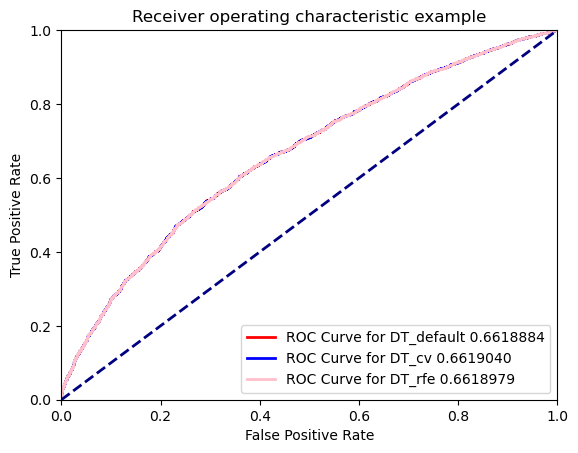

In [38]:
plt.plot(fpr_dt, tpr_dt, label='ROC Curve for DT_default {:.7f}'.format(roc_index_dt), color='red', lw=2)
plt.plot(fpr_dt_cv, tpr_dt_cv, label='ROC Curve for DT_cv {:.7f}'.format(roc_index_dt_cv), color='blue', lw=2)
plt.plot(fpr_dt_rfe, tpr_dt_rfe, label='ROC Curve for DT_rfe {:.7f}'.format(roc_index_dt_rfe), color='pink', lw=2)

# plt.plot(fpr[2], tpr[2], color='darkorange',
#          lw=lw, label='ROC curve (area = %0.2f)' % roc_auc[2])
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

In [39]:
import pickle
lr_best = model_cv
roc_index_lr_best = roc_index_dt_cv
tpr_lr_best = tpr_dt_cv
fpr_lr_best = fpr_dt_cv
with open('LR.pickle', 'wb') as f:
    pickle.dump([lr_best,roc_index_lr_best, fpr_lr_best, tpr_lr_best], f)